## Energy Recovery Unit (ERV) Tutorial
* This tutorial covers fault condition 16 for accessing an AHU with air side energy recovery. If there are any enhancements to the tutorial or fault logic please submit a git issue!
* Updated 9/6/24
* Dataset is available here: https://drive.google.com/file/d/1lDGv2Ei3dTHKFKtvU7oPp-TmTrfEznA0/view?usp=sharing

In [1]:
# pip install open-fdd --upgrade

As shown in the screenshot, the ERV unit for the AHU is circled, highlighting outdoor inlet and exit temperatures as well as exhaust side inlet and outlet temperature values. These temperature differentials are critical for assessing ERV performance. Manufacturers typically provide detailed cut sheets and performance charts that are used in HVAC design, diving deep into the intricacies of energy recovery. Factors such as the temperature delta between exhaust and outdoor air, humidity levels, and airflow rates all play a role in determining heat recovery efficiency. For example, as exhaust airflow decreases, ERV effectiveness in both sensible and latent heat exchange improves. However, this also reduces the ERV's ability to alleviate the load on the supply air, making it more efficient at heat and moisture exchange but less effective at reducing overall system load.

In IoT, MBx, or RCx applications, the data is often retrieved remotely, and these detailed manufacturer performance curves may not be available. This necessitates a more simplified approach to evaluating ERV performance. A basic method involves assessing the efficiency of heat transfer between the outdoor and exhaust air streams, and flagging faults if the efficiency falls outside a particular range for given conditions. For instance, during colder outdoor conditions when the ERV is capturing warm exhaust air, an efficiency of 60-70% might be expected. In warmer conditions where the outside air is hot and the exhaust air is cooler, the efficiency may drop to 50-70% or lower. A simplified approach could be to set up fault logic that flags instances where the calculated efficiency at each time step falls outside expected ranges.

However, for a more sophisticated assessment, additional data such as airflow rates, humidity levels, and system pressure would be required to model the ERV's performance more accurately. This would allow for a more dynamic calculation of efficiency under varying conditions, taking into account factors like latent heat transfer, real-time performance metrics, and potential anomalies. Unfortunately, such granular data is often unavailable in field conditions, making a simplified approach the most practical solution.

It's important to note that the ERV shown is a desiccant wheel type that rotates within a control loop, driving the entire air handling unit (AHU). Other ERVs, such as constant volume systems with blower motors, may be stationary. For example, ERVs could be used to ventilate locker rooms in schools or multiple floors of toilets in office buildings, bringing fresh outside air into the AHU airstream. Keep in mind that latent loads, such as humidity, are also transferred along with sensible heat in these systems, adding another layer of complexity to the energy recovery process.

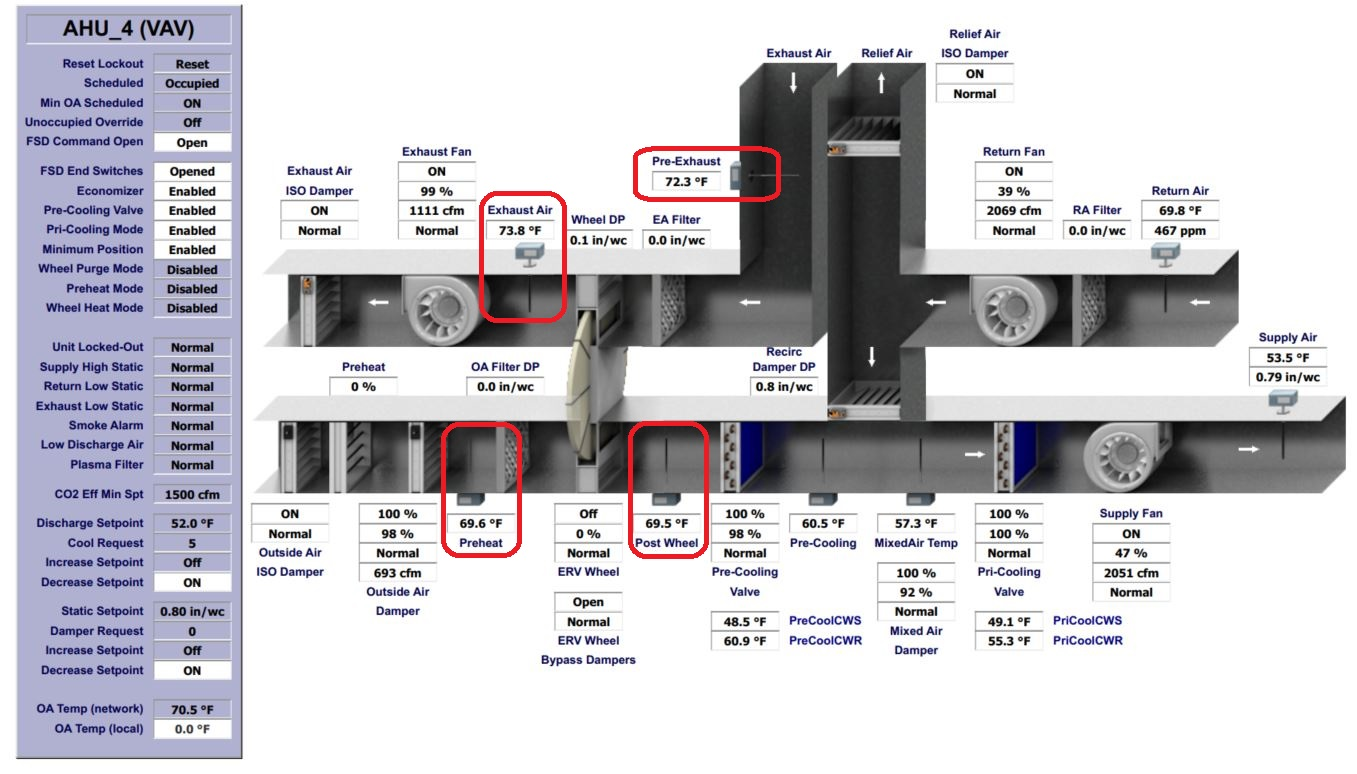

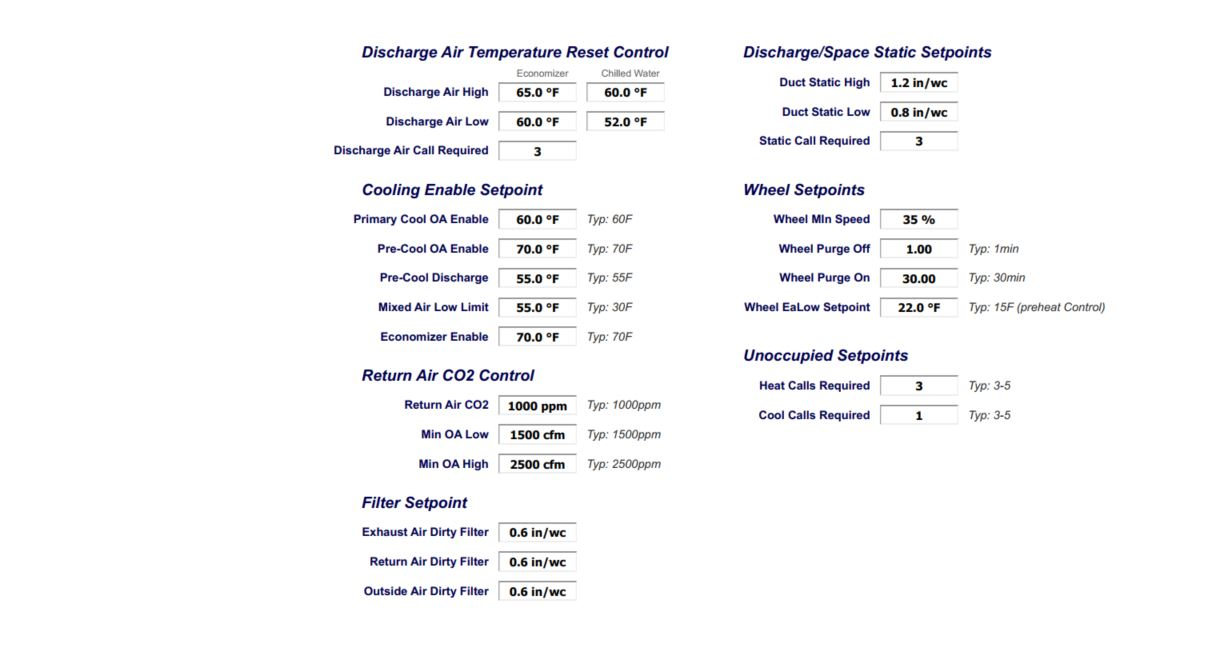

In [2]:
# display BAS screenshots

from IPython.display import Image, display

# Specify the path to your JPEG file
image_path1 = r"C:\Users\bbartling\Documents\AHU4.jpg"
image_path2 = r"C:\Users\bbartling\Documents\AHU4_points.jpg"

# Display the images
display(Image(filename=image_path1))
display(Image(filename=image_path2))

In [3]:
import pandas as pd
import numpy as np


In [4]:
# Load your data
ahu_data = r"C:\Users\bbartling\Documents\ahu4_data.csv"
df = pd.read_csv(ahu_data)

df.head()

,timestamp,AHU1_PostWheelTemp (°F),AHU1_EA_Flow (cfm),AHU1_CW_ValveAO (%),AHU1_MA_RA_DamperAO (%),AHU1_EA_FanSpeed (%),AHU1_EATemp (°F),AHU1_MATemp (°F),AHU1_PreCoolValveAO (%),AHU1_PreEA_Temp (°F),...,AV2_7_SpaceTemp,AV2_15_SpaceTemp,AV1_48_Co2,AV1_48_SpaceTemp,AV3_6_SpaceTemp,AV3_28B_SpaceTemp,AV4_6_Co2,AV4_6_SpaceTemp,AV4_17_SpaceTemp,AV4_17_Co2
0,2023-10-01 00:00:00,70.8,1199.0,32.0,88.0,100.0,73.7,60.0,87.0,70.9,...,71.77,69.73,402.67,70.29,72.38,73.22,407.81,71.8,71.52,400.6
1,2023-10-01 00:05:00,70.8,1199.0,32.0,88.0,100.0,73.7,60.0,87.0,70.9,...,71.77,69.73,402.67,70.29,72.38,73.22,407.81,71.8,71.52,400.6
2,2023-10-01 00:10:00,70.8,1192.0,37.0,90.0,100.0,73.7,60.2,90.0,70.9,...,71.77,69.73,402.67,70.29,72.38,73.22,407.81,71.8,71.52,400.6
3,2023-10-01 00:15:00,70.8,1197.0,38.0,85.0,100.0,73.7,59.4,89.0,70.9,...,71.77,69.73,402.67,70.29,72.38,73.22,407.81,71.8,71.52,400.6
4,2023-10-01 00:20:00,70.7,1200.0,40.0,89.0,100.0,73.6,60.2,90.0,70.9,...,71.77,69.73,402.67,70.29,72.38,73.22,407.81,71.8,71.52,400.6


Set the timestamp col as dataframe index

In [5]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)

df.head()

,AHU1_PostWheelTemp (°F),AHU1_EA_Flow (cfm),AHU1_CW_ValveAO (%),AHU1_MA_RA_DamperAO (%),AHU1_EA_FanSpeed (%),AHU1_EATemp (°F),AHU1_MATemp (°F),AHU1_PreCoolValveAO (%),AHU1_PreEA_Temp (°F),AHU1_DAT (°F),...,AV2_7_SpaceTemp,AV2_15_SpaceTemp,AV1_48_Co2,AV1_48_SpaceTemp,AV3_6_SpaceTemp,AV3_28B_SpaceTemp,AV4_6_Co2,AV4_6_SpaceTemp,AV4_17_SpaceTemp,AV4_17_Co2
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-10-01 00:00:00,70.8,1199.0,32.0,88.0,100.0,73.7,60.0,87.0,70.9,60.1,...,71.77,69.73,402.67,70.29,72.38,73.22,407.81,71.8,71.52,400.6
2023-10-01 00:05:00,70.8,1199.0,32.0,88.0,100.0,73.7,60.0,87.0,70.9,60.1,...,71.77,69.73,402.67,70.29,72.38,73.22,407.81,71.8,71.52,400.6
2023-10-01 00:10:00,70.8,1192.0,37.0,90.0,100.0,73.7,60.2,90.0,70.9,60.3,...,71.77,69.73,402.67,70.29,72.38,73.22,407.81,71.8,71.52,400.6
2023-10-01 00:15:00,70.8,1197.0,38.0,85.0,100.0,73.7,59.4,89.0,70.9,60.2,...,71.77,69.73,402.67,70.29,72.38,73.22,407.81,71.8,71.52,400.6
2023-10-01 00:20:00,70.7,1200.0,40.0,89.0,100.0,73.6,60.2,90.0,70.9,60.2,...,71.77,69.73,402.67,70.29,72.38,73.22,407.81,71.8,71.52,400.6


The code below filters the dataset for just AHU4 data. There are also 3 other AHUs in this dataset with the same ERV setup if it is desired to practice some FDD reports.

In [6]:
# Filter columns that start with 'AHU4_'
ahu4_columns = [col for col in df.columns if col.startswith('AHU4_')]

# Reindex the DataFrame with the filtered columns
df = df[ahu4_columns]

df.head()


,AHU4_PostWheelTemp (°F),AHU4_EA_Flow (cfm),AHU4_CW_ValveAO (%),AHU4_MA_RA_DamperAO (%),AHU4_EA_FanSpeed (%),AHU4_EATemp (°F),AHU4_MATemp (°F),AHU4_PreCoolValveAO (%),AHU4_PreEA_Temp (°F),AHU4_DAT (°F),...,AHU4_PreHeatTemp_value (°F),AHU4_OA_Flow_value (cfm),AHU4_SaFanFlow_value (cfm),AHU4_RATemp_value (°F),AHU4_SaFanSpeedAO_value (%),AHU4_WheelSpeedAO_value (%),AHU4_SaStatic_value (in/wc),AHU4_RA_Flow_value (cfm),AHU4_StaticSPt,AHU4_DischargeSPt
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-10-01 00:00:00,69.5,846.0,65.0,58.0,99.0,72.8,59.8,100.0,69.1,51.7,...,71.7,0.0,1427.0,67.8,41.0,100.0,0.80,1986.0,0.8,52.0
2023-10-01 00:05:00,69.5,846.0,65.0,58.0,99.0,72.8,59.8,100.0,69.1,51.7,...,71.7,0.0,1427.0,67.8,41.0,100.0,0.80,1986.0,0.8,52.0
2023-10-01 00:10:00,69.4,836.0,73.0,61.0,99.0,72.7,60.4,100.0,69.0,52.6,...,71.6,0.0,1465.0,67.8,42.0,100.0,0.79,1957.0,0.8,52.0
2023-10-01 00:15:00,69.4,833.0,73.0,62.0,99.0,72.7,60.2,100.0,69.0,52.5,...,71.6,0.0,1445.0,67.8,43.0,100.0,0.81,1941.0,0.8,52.0
2023-10-01 00:20:00,69.4,833.0,73.0,62.0,99.0,72.7,60.2,100.0,69.0,52.5,...,71.6,0.0,1445.0,67.8,43.0,100.0,0.81,1941.0,0.8,52.0


In [7]:
df.columns

Index(['AHU4_PostWheelTemp (°F)', 'AHU4_EA_Flow (cfm)', 'AHU4_CW_ValveAO (%)',
       'AHU4_MA_RA_DamperAO (%)', 'AHU4_EA_FanSpeed (%)', 'AHU4_EATemp (°F)',
       'AHU4_MATemp (°F)', 'AHU4_PreCoolValveAO (%)', 'AHU4_PreEA_Temp (°F)',
       'AHU4_DAT (°F)', 'AHU4_RA_CO2', 'AHU4_PreHeatTemp_value (°F)',
       'AHU4_OA_Flow_value (cfm)', 'AHU4_SaFanFlow_value (cfm)',
       'AHU4_RATemp_value (°F)', 'AHU4_SaFanSpeedAO_value (%)',
       'AHU4_WheelSpeedAO_value (%)', 'AHU4_SaStatic_value (in/wc)',
       'AHU4_RA_Flow_value (cfm)', 'AHU4_StaticSPt', 'AHU4_DischargeSPt'],
      dtype='object')

The code below uses a built-in utility feature of *open-fdd* to apply a rolling average to the data when the time steps are one minute or less. ASHRAE recommends using 1-minute data with 5-minute rolling averages. If the data has time steps greater than 1 minute, no rolling average is applied.

In [8]:
from open_fdd.air_handling_unit.faults.helper_utils import HelperUtils

utils = HelperUtils()

df = utils.apply_rolling_average_if_needed(df)

frequency a rolling average will be automatically applied


The code checks for empty rows in the df or NaNs

In [9]:
# Check for NaN values in each column
for col in df.columns:
    if df[col].isnull().any():
        print(f"NaN values found in column: {col}")

        # Remove rows with any NaN values, then forward and backfill
        df = df.dropna().ffill().bfill()
        print("DataFrame has been cleaned for NaNs and has also been forward and backfilled.")

In [10]:
# Checking data types of each column
print("Data Types:")
print(df.dtypes)

Data Types:
AHU4_PostWheelTemp (°F)        float64
AHU4_EA_Flow (cfm)             float64
AHU4_CW_ValveAO (%)            float64
AHU4_MA_RA_DamperAO (%)        float64
AHU4_EA_FanSpeed (%)           float64
AHU4_EATemp (°F)               float64
AHU4_MATemp (°F)               float64
AHU4_PreCoolValveAO (%)        float64
AHU4_PreEA_Temp (°F)           float64
AHU4_DAT (°F)                  float64
AHU4_RA_CO2                    float64
AHU4_PreHeatTemp_value (°F)    float64
AHU4_OA_Flow_value (cfm)       float64
AHU4_SaFanFlow_value (cfm)     float64
AHU4_RATemp_value (°F)         float64
AHU4_SaFanSpeedAO_value (%)    float64
AHU4_WheelSpeedAO_value (%)    float64
AHU4_SaStatic_value (in/wc)    float64
AHU4_RA_Flow_value (cfm)       float64
AHU4_StaticSPt                 float64
AHU4_DischargeSPt              float64
dtype: object


This code checks for maximum values. The *open-fdd* fault logic uses control system I/O to determine the mode that the AHU is operating in. Analog outputs, commonly expressed as a percentage of command (such as VFD speed or damper/valve command), need to be a float between 0.0 and 1.0. However, some control system data represent these percentages as floats from 0.0 to 100.0. To ensure accurate fault detection, it's essential to normalize these percentage values to a consistent range of 0.0 to 1.0 when necessary.

Fault condition 16 alone doesnt require this but is good practice if using open-fdd

In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("\nMax Values:")
    print(df.max(numeric_only=True))


Max Values:
AHU4_PostWheelTemp (°F)           90.30
AHU4_EA_Flow (cfm)              1934.00
AHU4_CW_ValveAO (%)              100.00
AHU4_MA_RA_DamperAO (%)          100.00
AHU4_EA_FanSpeed (%)             100.00
AHU4_EATemp (°F)                  95.90
AHU4_MATemp (°F)                  86.00
AHU4_PreCoolValveAO (%)          100.00
AHU4_PreEA_Temp (°F)              85.60
AHU4_DAT (°F)                     96.00
AHU4_RA_CO2                      759.00
AHU4_PreHeatTemp_value (°F)       94.50
AHU4_OA_Flow_value (cfm)        3716.00
AHU4_SaFanFlow_value (cfm)     12097.00
AHU4_RATemp_value (°F)            82.90
AHU4_SaFanSpeedAO_value (%)      100.00
AHU4_WheelSpeedAO_value (%)      100.00
AHU4_SaStatic_value (in/wc)        2.05
AHU4_RA_Flow_value (cfm)        7797.00
AHU4_StaticSPt                     1.20
AHU4_DischargeSPt                 65.00
dtype: float64


In [12]:
# OPTIONAL CONVERT AO's based on above info if they are floats between 0.0 and 100.0. 

# the floats between 0.0 and 100.0 so we need to convert to 0.0 and 1.0 ranges
percentage_columns = [
    ["AHU4_MA_RA_DamperAO (%)"],
    ["AHU4_SaFanSpeedAO_value (%)"],
    ["AHU4_CW_ValveAO (%)"],
    ["AHU4_WheelSpeedAO_value (%)"],
    ["AHU4_EA_FanSpeed (%)"]
]

for col in percentage_columns:
    df[col] = df[col] / 100.0

df.head()



,AHU4_PostWheelTemp (°F),AHU4_EA_Flow (cfm),AHU4_CW_ValveAO (%),AHU4_MA_RA_DamperAO (%),AHU4_EA_FanSpeed (%),AHU4_EATemp (°F),AHU4_MATemp (°F),AHU4_PreCoolValveAO (%),AHU4_PreEA_Temp (°F),AHU4_DAT (°F),...,AHU4_PreHeatTemp_value (°F),AHU4_OA_Flow_value (cfm),AHU4_SaFanFlow_value (cfm),AHU4_RATemp_value (°F),AHU4_SaFanSpeedAO_value (%),AHU4_WheelSpeedAO_value (%),AHU4_SaStatic_value (in/wc),AHU4_RA_Flow_value (cfm),AHU4_StaticSPt,AHU4_DischargeSPt
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-10-01 00:00:00,69.5,846.0,0.65,0.58,0.99,72.8,59.8,100.0,69.1,51.7,...,71.7,0.0,1427.0,67.8,0.41,1.0,0.80,1986.0,0.8,52.0
2023-10-01 00:05:00,69.5,846.0,0.65,0.58,0.99,72.8,59.8,100.0,69.1,51.7,...,71.7,0.0,1427.0,67.8,0.41,1.0,0.80,1986.0,0.8,52.0
2023-10-01 00:10:00,69.4,836.0,0.73,0.61,0.99,72.7,60.4,100.0,69.0,52.6,...,71.6,0.0,1465.0,67.8,0.42,1.0,0.79,1957.0,0.8,52.0
2023-10-01 00:15:00,69.4,833.0,0.73,0.62,0.99,72.7,60.2,100.0,69.0,52.5,...,71.6,0.0,1445.0,67.8,0.43,1.0,0.81,1941.0,0.8,52.0
2023-10-01 00:20:00,69.4,833.0,0.73,0.62,0.99,72.7,60.2,100.0,69.0,52.5,...,71.6,0.0,1445.0,67.8,0.43,1.0,0.81,1941.0,0.8,52.0


The code below removes rows of data where the values are zero. I noticed that when running the code, the plots appeared odd due to a few rows where temperature sensors read zero for some unknown reason. These zero values could be considered outliers since it’s unlikely for temperature sensors to read zero during a hot and humid July summer in the upper Midwest USA.

In [13]:
df = df[df["AHU4_PreHeatTemp_value (°F)"] != 0]

The code below creates a copy of the dataframe, which is then used to zoom into smaller, monthly views of the data for more detailed analysis.

In [14]:
# OPTIONAL is make smaller monthly datasets\
# after everything is cleaned up for better plots

# save this as a copy for later
df_copy_for_monthly_reports = df.copy()


This is a minimal config dictionary used for this fault equation. See other examples for larger config dictionaries. It should be fairly self-explanatory, but the parameter `'OAT_RAT_DELTA_MIN': 15.0` is the required delta temperature between the ERV outdoor air inlet and exhaust air inlet temperatures. To assess a fault, this delta temperature, as determined by `OAT_RAT_DELTA_MIN`, needs to exceed the set value, and the parameter `"ERV_OAT_ENTER_COL": "AHU4_PreHeatTemp_value (°F)"` must be outside the following ranges:

- `"OAT_LOW_THRESHOLD": 30.0`
- `"OAT_HIGH_THRESHOLD": 80.0`

If those conditions are satisfied, the efficiency of the ERV is calculated and will be flagged as a fault if the efficiency falls outside the ranges defined by the parameters:

- `"ERV_EFFICIENCY_MIN_HEATING": 0.7`
- `"ERV_EFFICIENCY_MAX_HEATING": 0.8`
- `"ERV_EFFICIENCY_MIN_COOLING": 0.45`
- `"ERV_EFFICIENCY_MAX_COOLING": 0.6`

For example, if the `"ERV_OAT_ENTER_COL": "AHU4_PreHeatTemp_value (°F)"` is less than or equal to the `"OAT_LOW_THRESHOLD"`, the calculated outside air side of the ERV needs to fall within the range of 70-80%, as defined by `"ERV_EFFICIENCY_MIN_HEATING": 0.7` and `"ERV_EFFICIENCY_MAX_HEATING": 0.8`. Similarly, in warm weather, if the `"ERV_OAT_ENTER_COL": "AHU4_PreHeatTemp_value (°F)"` exceeds the `"OAT_HIGH_THRESHOLD": 80.0`, and the `OAT_RAT_DELTA_MIN` is 15.0, a fault will be flagged if the calculated efficiency is outside the ranges of `"ERV_EFFICIENCY_MIN_COOLING": 0.45` and `"ERV_EFFICIENCY_MAX_COOLING": 0.6`.

Keep in mind that ERVs are generally optimized for heating applications, at least in colder climates where the majority of months are cold. However, HVAC designs in other climates could differ. Adjust parameters as necessary, following engineering best practices. Additionally, calculated efficiencies that are too high could indicate faulty temperature sensors. 

In [15]:


# Configuration dictionary
config_dict = {

    
    # timestamp column name
    'INDEX_COL_NAME': "timestamp",

    'DUCT_STATIC_COL': "SaStatic",
    'DUCT_STATIC_SETPOINT_COL': "Static_SP",
    'SUPPLY_VFD_SPEED_COL': "AHU4_SaFanSpeedAO_value (%)",

    # New ERV Fault 16 params
    "ERV_EFFICIENCY_MIN_HEATING": 0.7, 
    "ERV_EFFICIENCY_MAX_HEATING": 0.8,
    "ERV_EFFICIENCY_MIN_COOLING": 0.45,
    "ERV_EFFICIENCY_MAX_COOLING": 0.6,

    "OAT_LOW_THRESHOLD": 30.0,
    "OAT_HIGH_THRESHOLD": 80.0,

    "ERV_OAT_ENTER_COL": "AHU4_PreHeatTemp_value (°F)",
    "ERV_OAT_LEAVING_COL": "AHU4_PostWheelTemp (°F)",
    "ERV_EAT_ENTER_COL": "AHU4_PreEA_Temp (°F)",
    "ERV_EAT_LEAVING_COL": "AHU4_EATemp (°F)",

    'OAT_RAT_DELTA_MIN': 15.0,

    'TROUBLESHOOT_MODE': False,
    'ROLLING_WINDOW_SIZE': 10
}

In [16]:
# create empty dict to hold fault counts which we can do something with later

fault_counts = {}

When running fault checks by default, if faults are detected, a time-of-day histogram is automatically generated by open-fdd under the hood, though it can likely be ignored for this application. The key focus should be on the calculated efficiencies and the box plots of outdoor air temperatures during periods when the fault is true.

fc16_flag = 1 if temperature deltas and expected efficiency is ineffective for N consecutive values else 0 
Fault Condition 16: ERV is an ineffective heat transfer fault. This fault occurs when the ERV's efficiency is outside the acceptable range based on the delta temperature across the ERV outside air enter temperature and ERV outside air leaving temperature, indicating poor heat transfer. It considers both heating and cooling conditions where each have acceptable ranges in percentage for expected heat transfer efficiency. The percentage needs to be a float between 0.0 and 1.0.
Required inputs are the ERV outside air entering temperature, ERV outside air leaving temperature, ERV exhaust entering temperature, ERV exhaust leaving temperature, and AHU supply fan VFD speed.
Your config dictionary is mapped as: AHU4_PreHeatTemp_value (°F), AHU4_PostWheelTemp (°F), AHU4_PreEA_Temp (°F), AHU4_EATemp (°F), AHU4_SaFanSpeedAO_value (%)
FC16 Fault Sum: 10478
total days: 336.0
total hours: 8064


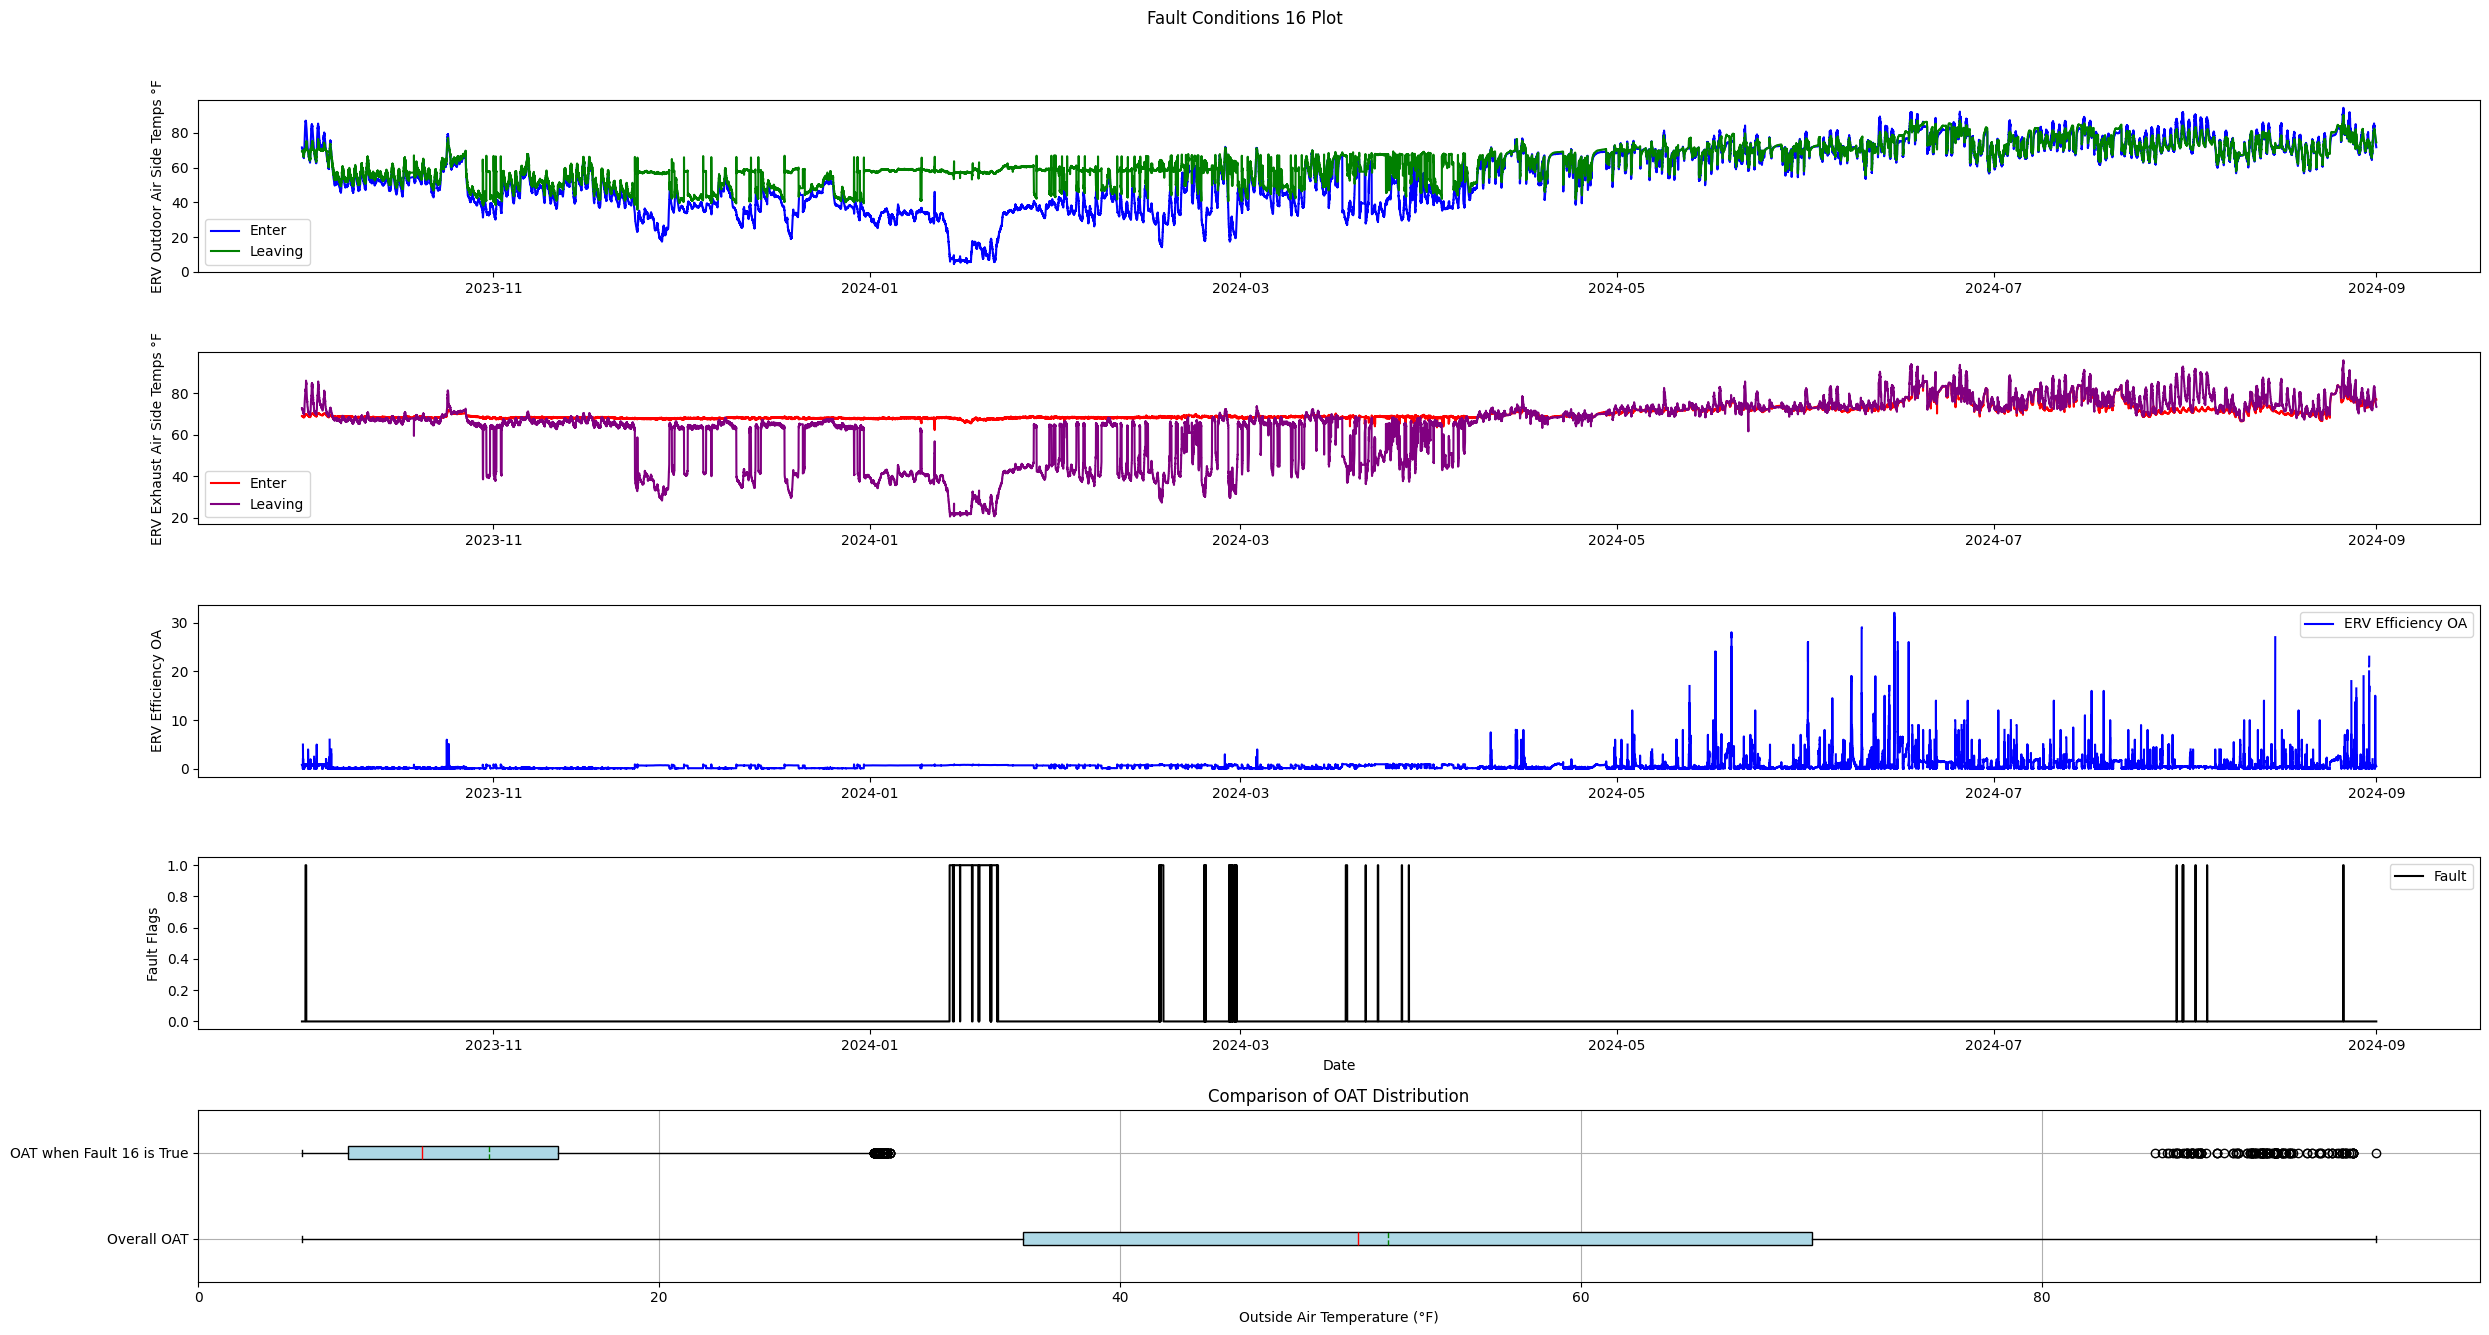

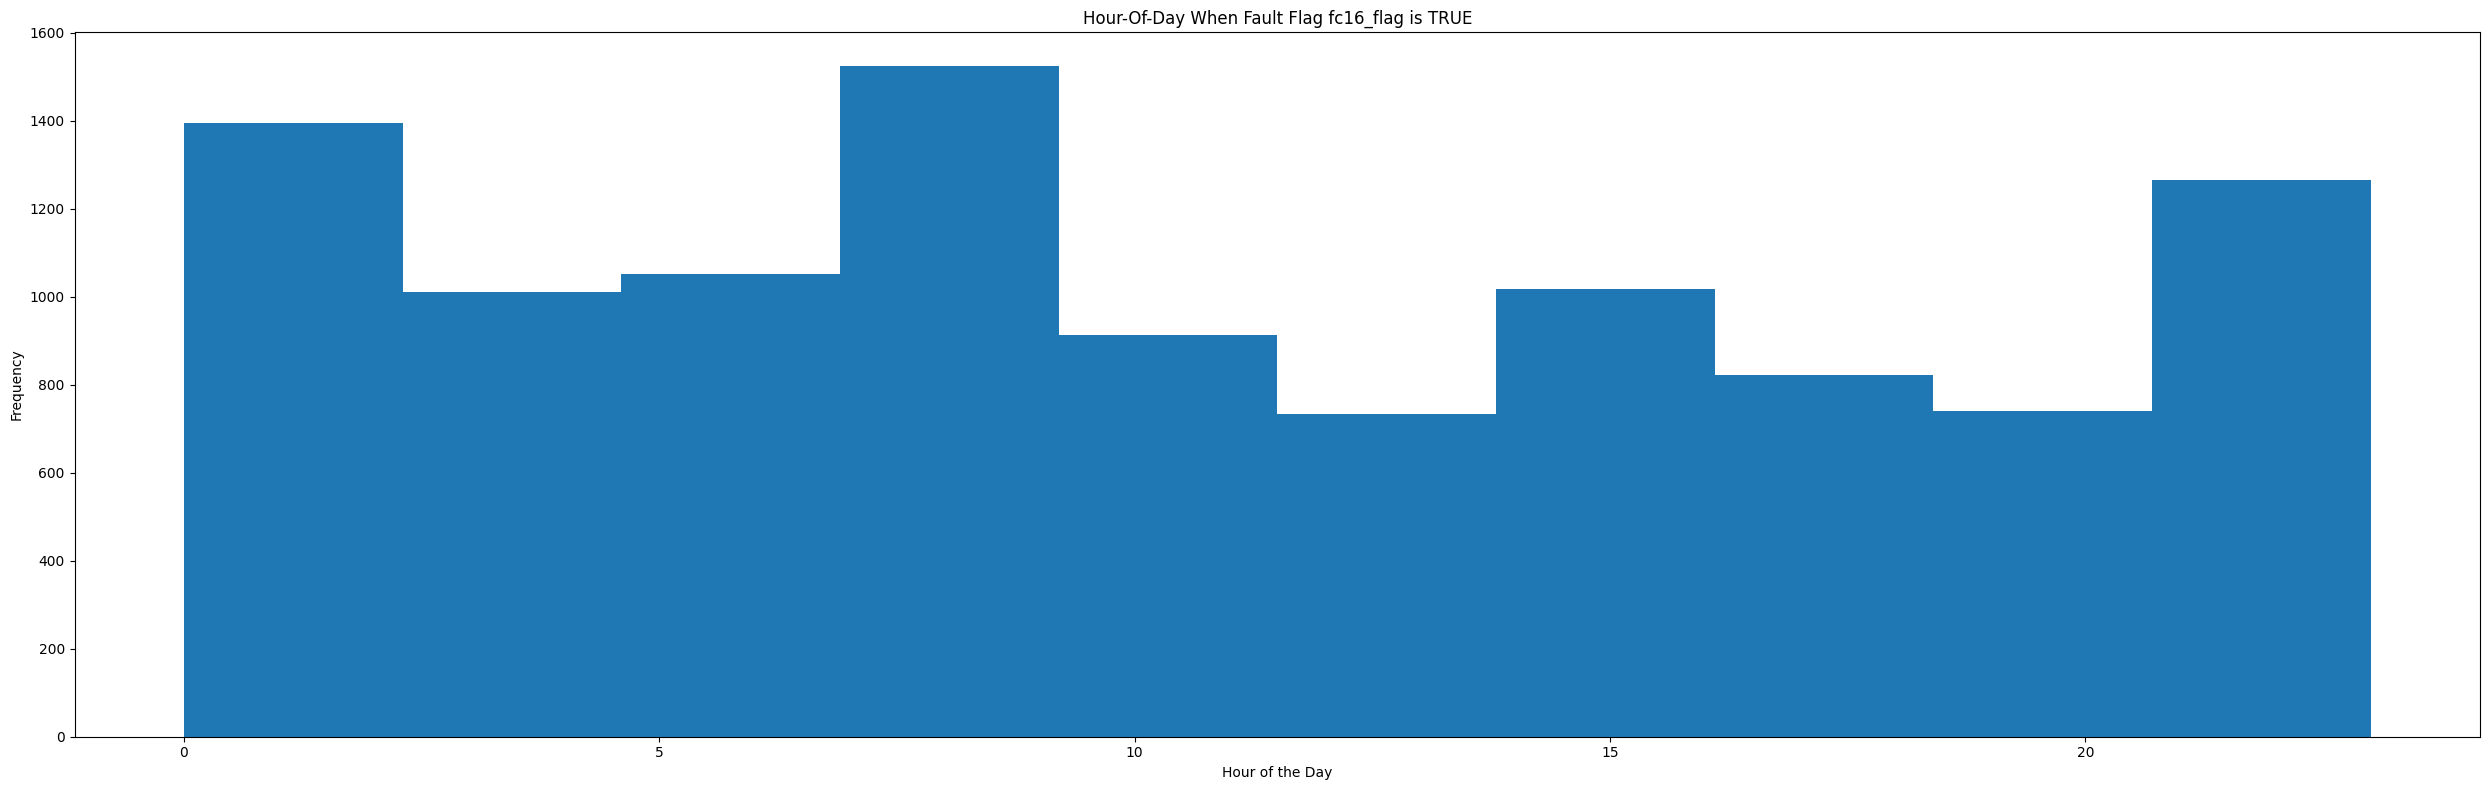

In [17]:
from open_fdd.air_handling_unit.faults import FaultConditionSixteen
from open_fdd.air_handling_unit.reports import FaultCodeSixteenReport

# Create an instance of FaultConditionOne
fc16 = FaultConditionSixteen(config_dict)
fc16_required_columns = fc16.get_required_columns()
print(fc16_required_columns)

# Apply the fault condition to the DataFrame
df_fc16 = fc16.apply(df)

fault_counts["fc16_fault_sum"] = df_fc16["fc16_flag"].sum()
print(f"FC16 Fault Sum: {fault_counts['fc16_fault_sum']}")


# Retrieve and print all the metrics (keys and values) from summarize_fault_times
fc16_report = FaultCodeSixteenReport(config_dict)
summary_metrics = fc16_report.summarize_fault_times(df_fc16)

''' also printed under the hood in open-fdd
# Print each key and value
for key, value in summary_metrics.items():
    print(f"{key}: {value}")
'''

# Generate and display the report if there is a fault
if fault_counts['fc16_fault_sum'] != 0:
    fc16_report.display_report_in_ipython(df_fc16)
else:
    print("No faults found.")


The code below runs the dataset copies for both January and July. In the January dataset, there may be potential fault positives, as during the coldest periods, the ERV efficiency exceeds 80%, indicating excellent heat transfer. Nonetheless, it's a valuable exercise to examine the data more closely.

In the July dataset, there are only a few faults, occurring during extreme outside air temperatures, as noted in the box plots. Keep in mind that the fault is only triggered when the AHU is running, and there is a 15°F delta between the exhaust and outdoor air inlet temperatures. The performance of the ERV desiccant wheel appears much weaker in cooling mode, suggesting that bypassing the wheel altogether during cooling could be advantageous for this particular unit. This is because the ERV desiccant wheel creates a pressure drop that the supply fan must overcome. 

When the AHU is in economizer mode, the ERV should typically be in "bypass" mode—assuming the control system has bypass dampers around the ERV components. Some systems, like constant volume blower fans used for locker rooms in schools, may not have this option. The additional fan energy required to overcome the ERV's pressure drop could outweigh the benefits of energy recovery under certain conditions, especially when heat transfer performance is poor. This tradeoff should always be considered by the consulting engineer when optimizing sequences.


Running analysis for January 2024...

fc16_flag = 1 if temperature deltas and expected efficiency is ineffective for N consecutive values else 0 
Fault Condition 16: ERV is an ineffective heat transfer fault. This fault occurs when the ERV's efficiency is outside the acceptable range based on the delta temperature across the ERV outside air enter temperature and ERV outside air leaving temperature, indicating poor heat transfer. It considers both heating and cooling conditions where each have acceptable ranges in percentage for expected heat transfer efficiency. The percentage needs to be a float between 0.0 and 1.0.
Required inputs are the ERV outside air entering temperature, ERV outside air leaving temperature, ERV exhaust entering temperature, ERV exhaust leaving temperature, and AHU supply fan VFD speed.
Your config dictionary is mapped as: AHU4_PreHeatTemp_value (°F), AHU4_PostWheelTemp (°F), AHU4_PreEA_Temp (°F), AHU4_EATemp (°F), AHU4_SaFanSpeedAO_value (%)
FC16 Fault Sum for 

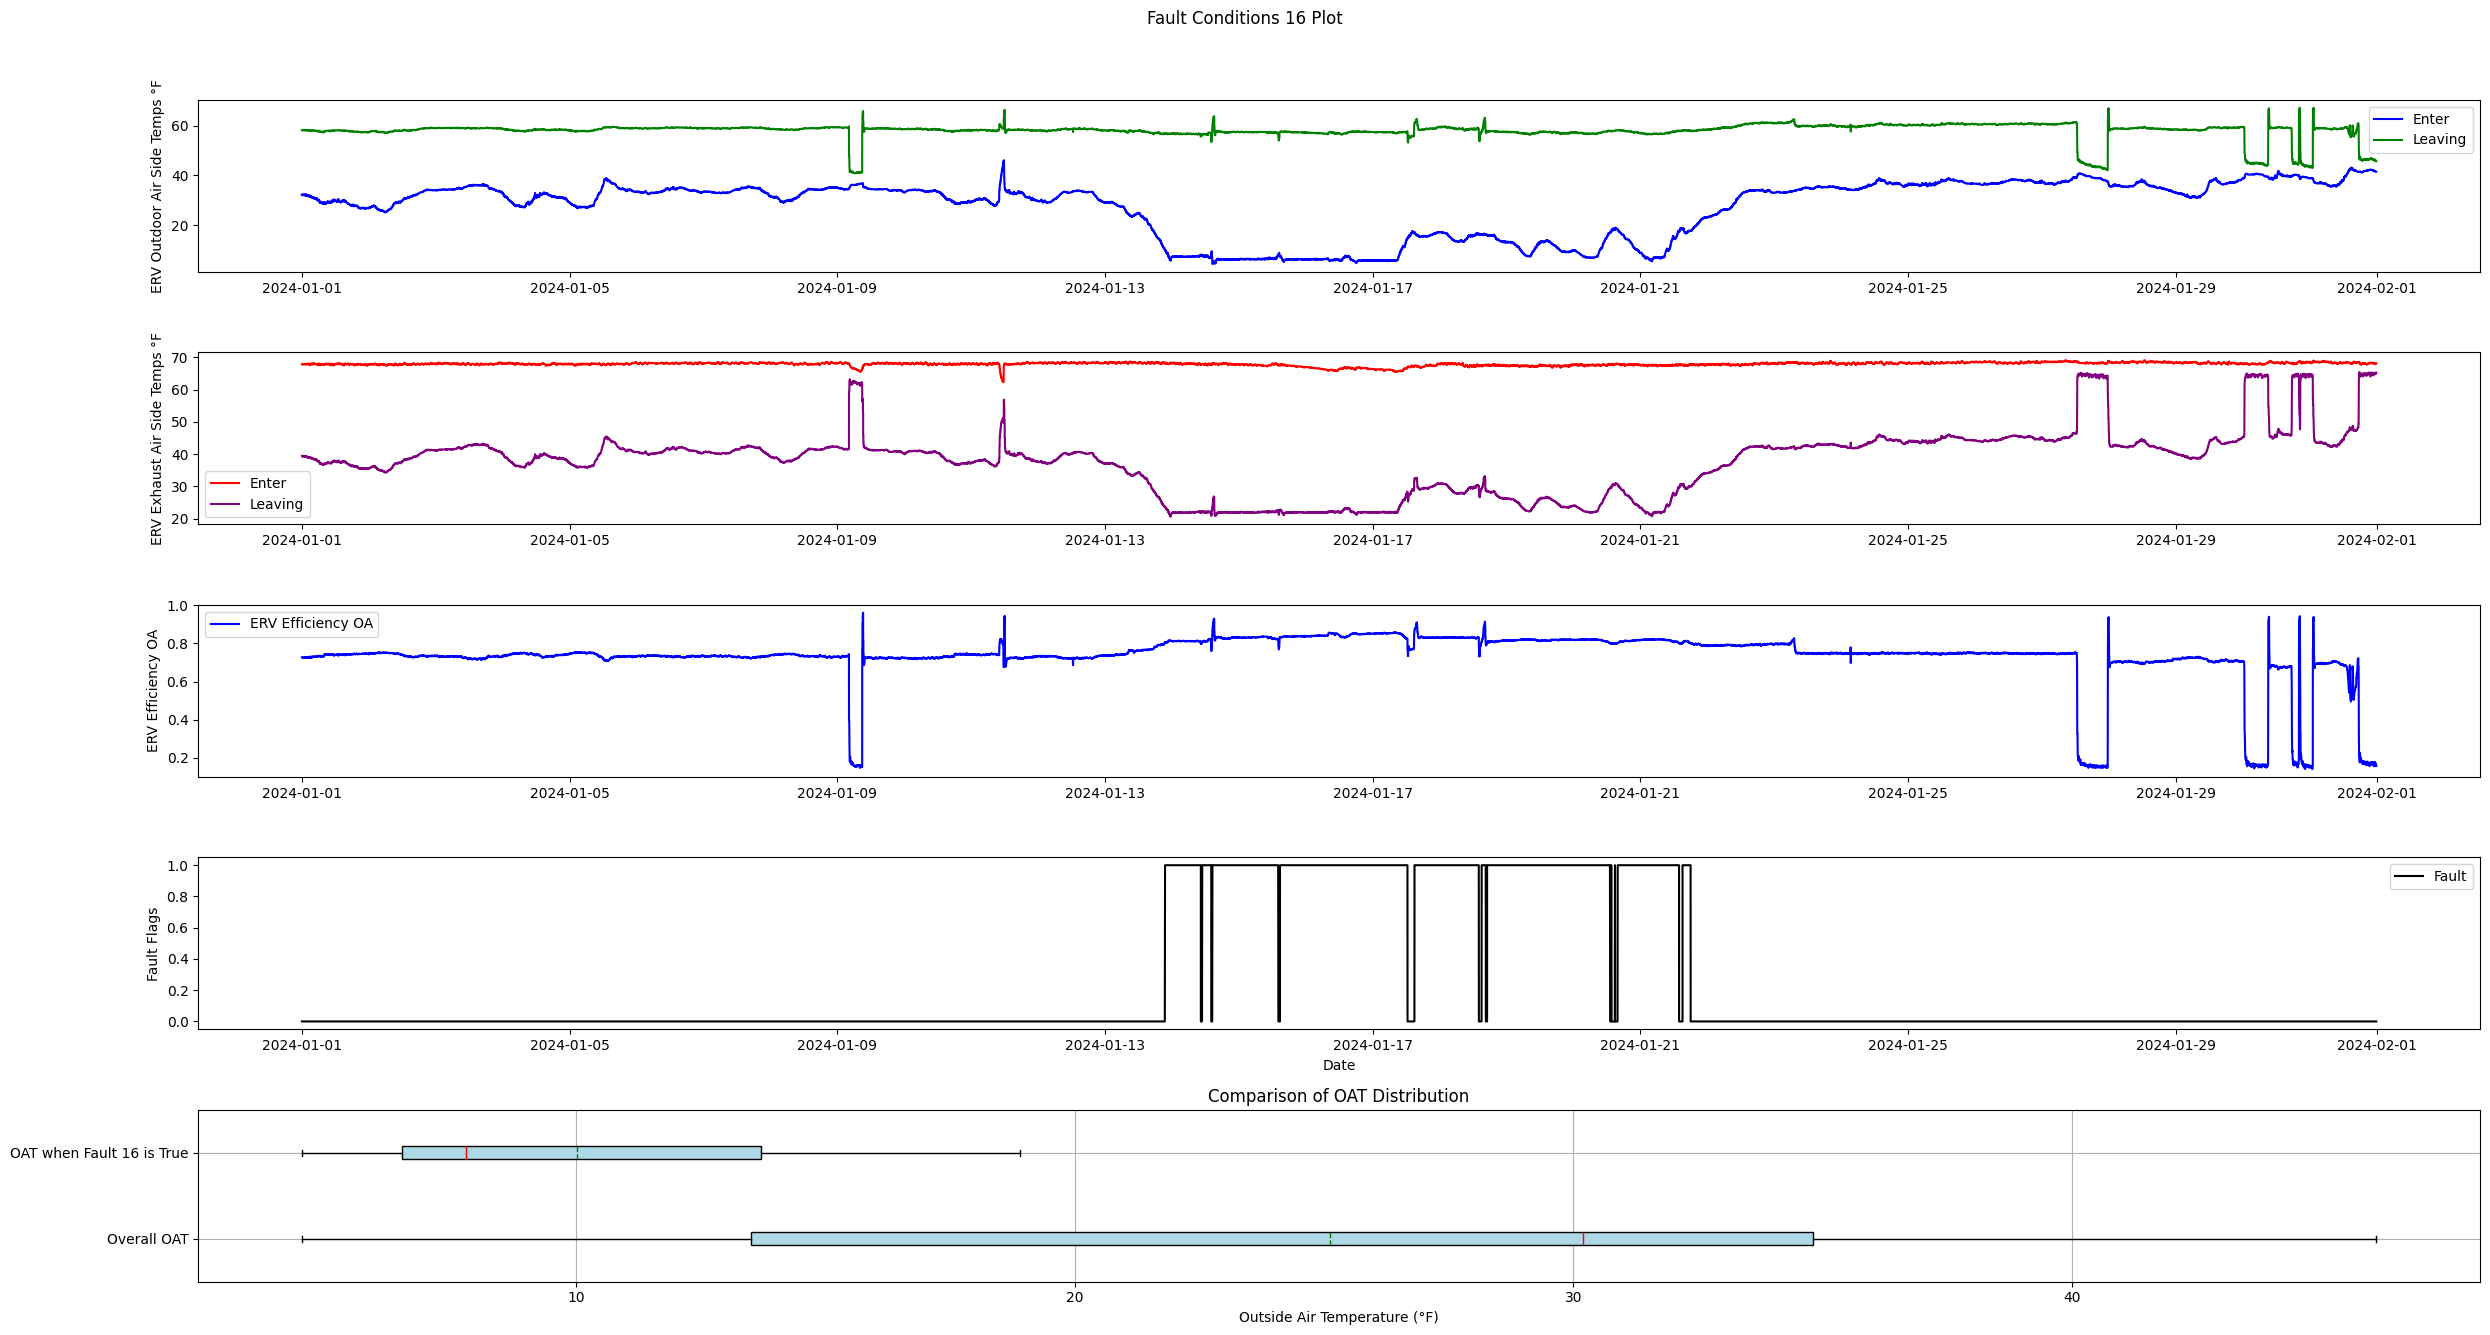

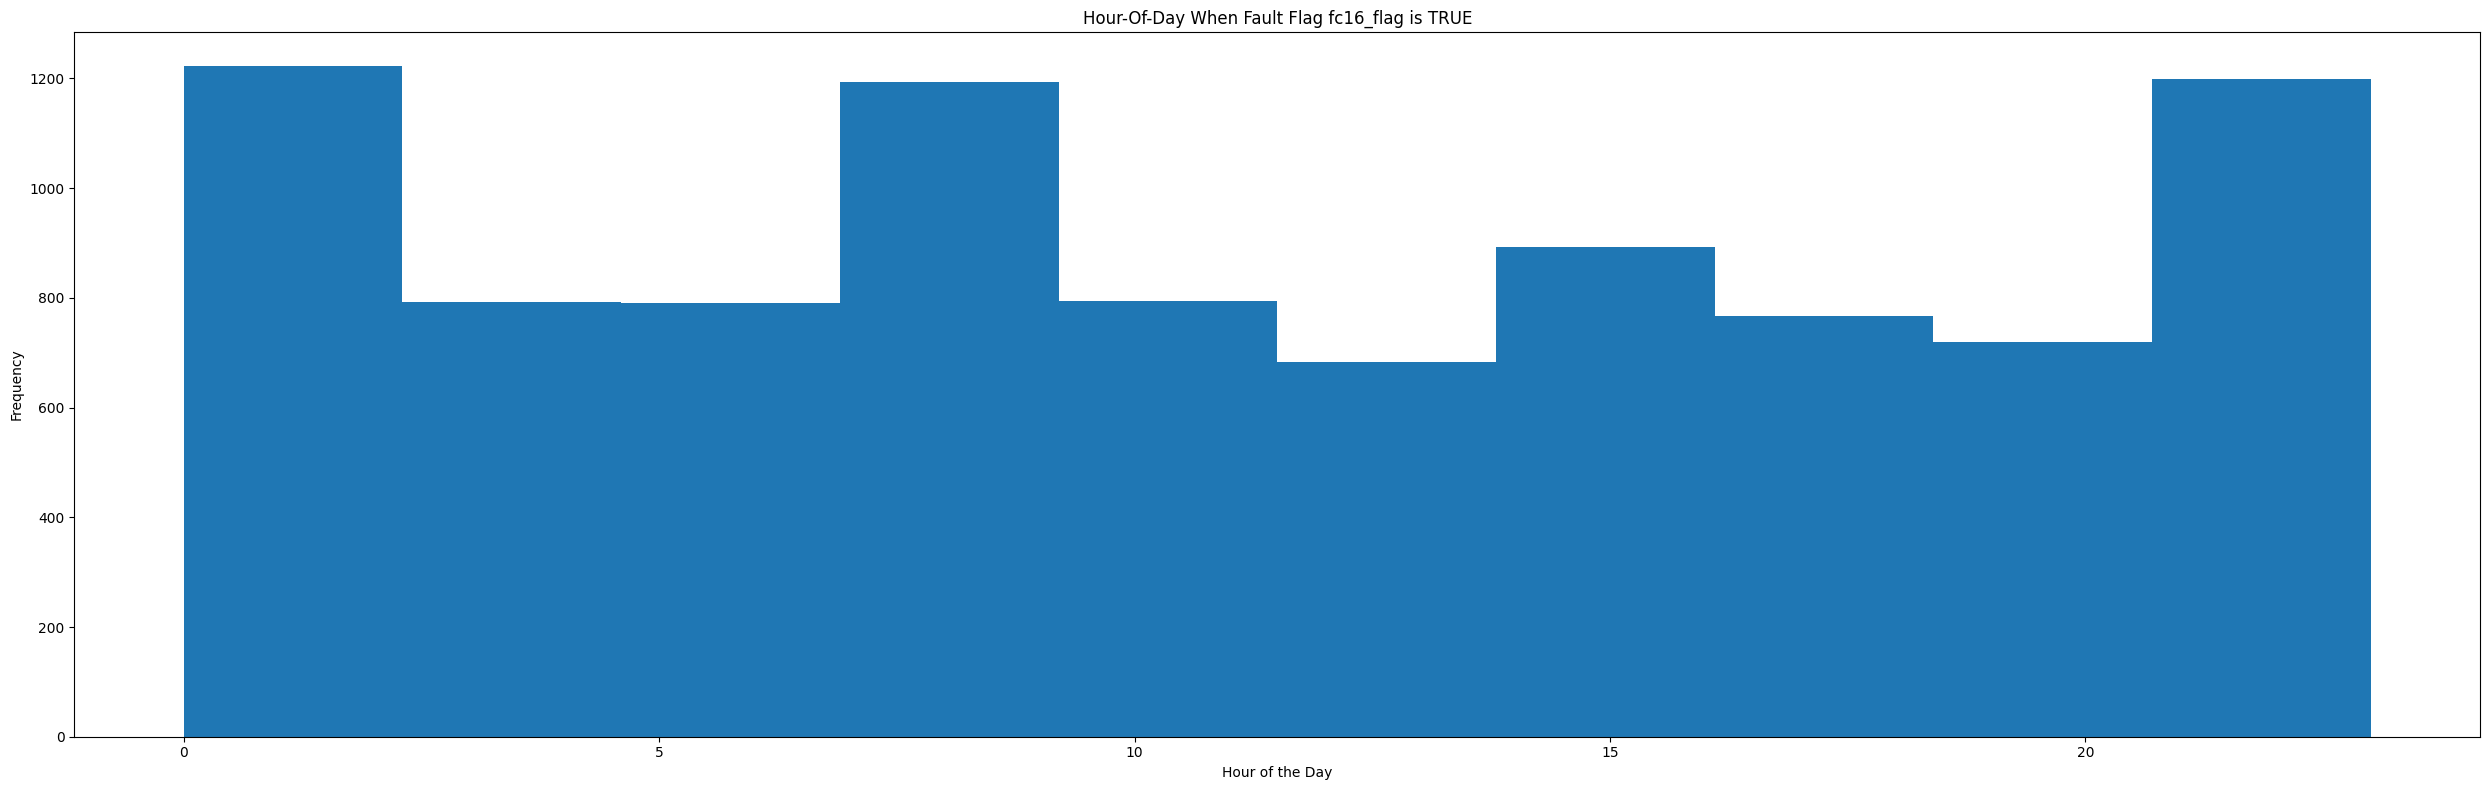


Running analysis for July 2024...

fc16_flag = 1 if temperature deltas and expected efficiency is ineffective for N consecutive values else 0 
Fault Condition 16: ERV is an ineffective heat transfer fault. This fault occurs when the ERV's efficiency is outside the acceptable range based on the delta temperature across the ERV outside air enter temperature and ERV outside air leaving temperature, indicating poor heat transfer. It considers both heating and cooling conditions where each have acceptable ranges in percentage for expected heat transfer efficiency. The percentage needs to be a float between 0.0 and 1.0.
Required inputs are the ERV outside air entering temperature, ERV outside air leaving temperature, ERV exhaust entering temperature, ERV exhaust leaving temperature, and AHU supply fan VFD speed.
Your config dictionary is mapped as: AHU4_PreHeatTemp_value (°F), AHU4_PostWheelTemp (°F), AHU4_PreEA_Temp (°F), AHU4_EATemp (°F), AHU4_SaFanSpeedAO_value (%)
FC16 Fault Sum for Jul

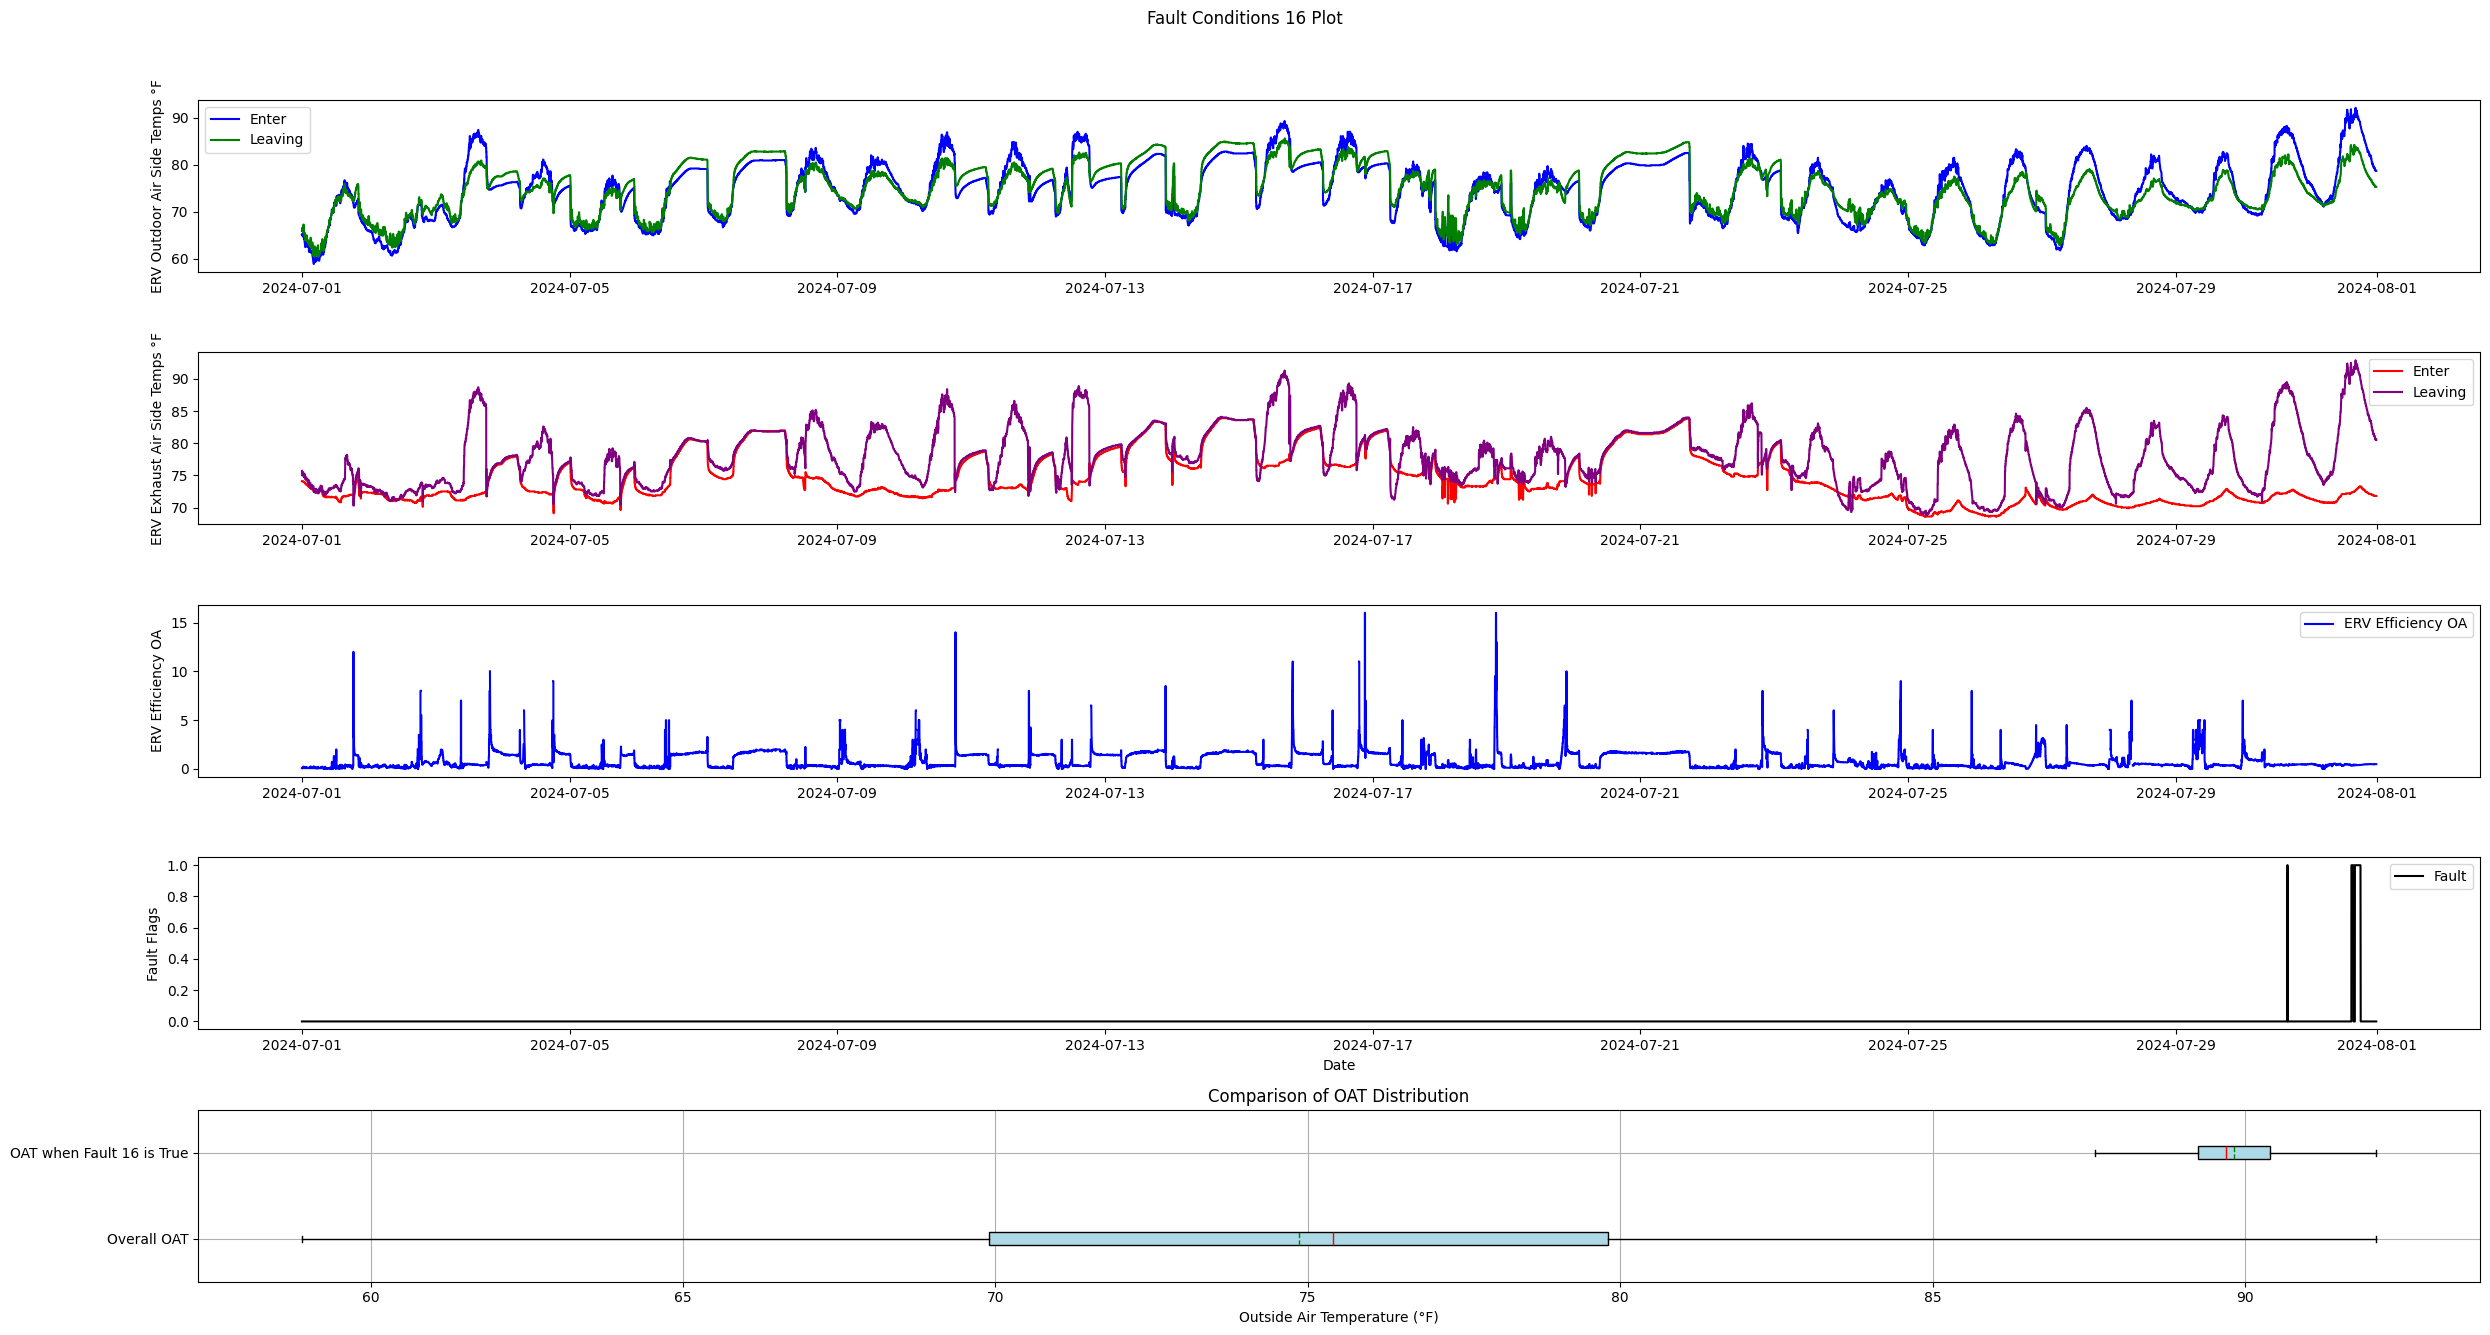

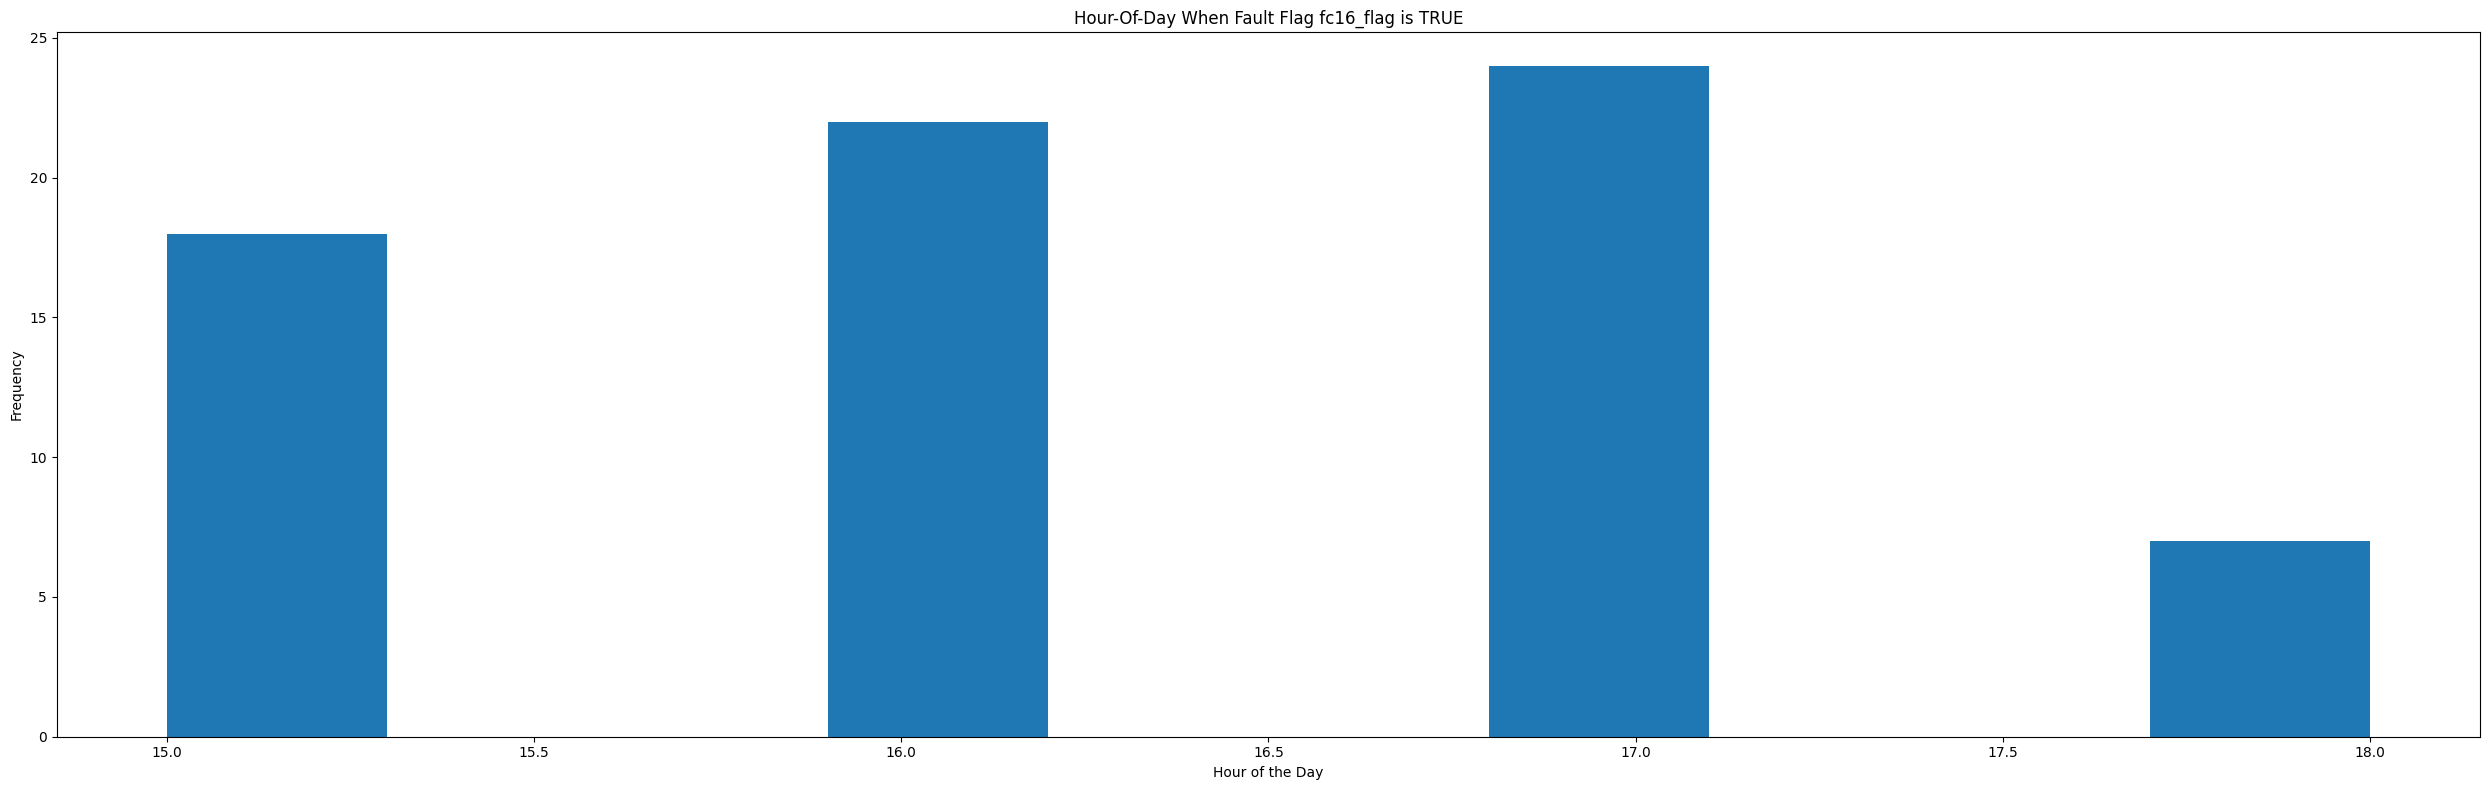

In [18]:


# OPTIONAL: Break out the DataFrame by month for better plots
dfs_by_month = {month: data for month, data in df_copy_for_monthly_reports.groupby(df.index.to_period("M"))}

# Access the DataFrames for January and July 2024
jan_df = dfs_by_month[pd.Period("2024-01")]
july_df = dfs_by_month[pd.Period("2024-07")]

# Function to run Fault Condition 16 analysis on a given DataFrame
def run_fc16_analysis(df, month_name, config_dict):
    print(f"\nRunning analysis for {month_name}...\n")
    
    # Create an instance of FaultConditionSixteen
    fc16 = FaultConditionSixteen(config_dict)
    fc16_required_columns = fc16.get_required_columns()
    print(fc16_required_columns)

    # Apply the fault condition to the DataFrame
    df_fc16 = fc16.apply(df)

    fault_sum = df_fc16["fc16_flag"].sum()
    print(f"FC16 Fault Sum for {month_name}: {fault_sum}")

    # Retrieve and print all the metrics (keys and values) from summarize_fault_times
    fc16_report = FaultCodeSixteenReport(config_dict)
    summary_metrics = fc16_report.summarize_fault_times(df_fc16)

    ''' also printed under the hood in open-fdd
    # Print each key and value
    for key, value in summary_metrics.items():
        print(f"{key}: {value}")
    '''

    # Generate and display the report if there is a fault
    if fault_sum != 0:
        fc16_report.display_report_in_ipython(df_fc16)
    else:
        print(f"No faults found for {month_name}.")

# Run the analysis for January 2024
run_fc16_analysis(jan_df, "January 2024", config_dict)

# Run the analysis for July 2024
run_fc16_analysis(july_df, "July 2024", config_dict)
